In [1]:
import cv2
import gc
import numpy as np
import os
import pandas as pd
import PIL.Image as Image
import tifffile as tiff

from matplotlib import pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm

In [2]:
OUTPUT_PNG = True
OUTPUT_NPY = False

ROI_SIZE = [0, 224, 224, 224]
STRID_SIZE = [0, 112, 112, 112]
IMAGE_NUM = 3

INPUT_DIR = Path("data/train")
OUTPUT_DIR = Path("working/")

In [3]:
def crop_image(image_id, input_dir, output_dir):

    output_data_dir = Path(output_dir / f"{image_id}")
    if not output_data_dir.exists():
        output_data_dir.mkdir()

    # Load label image
    inklabels_img = np.array(Image.open(str(input_dir / f"{image_id}" / "inklabels.png")))
    # inklabels_img = np.pad(inklabels_img, [(0, ROI_SIZE[int(image_id)]-inklabels_img.shape[1]%ROI_SIZE[int(image_id)]), (0, ROI_SIZE[int(image_id)]-inklabels_img.shape[0]%ROI_SIZE[int(image_id)])], 'constant')
    masks_img = np.array(Image.open(str(input_dir / f"{image_id}" / "mask.png")))
    # masks_img = np.pad(masks_img_org, [(0, ROI_SIZE[int(image_id)]-masks_img_org.shape[1]%ROI_SIZE[int(image_id)]), (0, ROI_SIZE[int(image_id)]-masks_img_org.shape[0]%ROI_SIZE[int(image_id)])], 'constant')

    # Get the scanning position of the image
    x_pos_list = []
    y_pos_list = []
    for y in range(0, inklabels_img.shape[0], STRID_SIZE[int(image_id)]):
        for x in range(0, inklabels_img.shape[1], STRID_SIZE[int(image_id)]):
            if inklabels_img[y:y+ROI_SIZE[int(image_id)], x:x+ROI_SIZE[int(image_id)]].max() > 0:
                #  if not (y+ROI_SIZE[int(image_id)] > masks_img_org.shape[0] or x+ROI_SIZE[int(image_id)] > masks_img_org.shape[1]):
                x_pos_list.append(x)
                y_pos_list.append(y)

    # Crop the image
    image_path_list = sorted(list(Path(input_dir / f"{image_id}" / "surface_volume").glob('*.tif')))
    for i, image_path in tqdm(enumerate(image_path_list), total=len(image_path_list), desc=f"Cropping images - {image_id}", dynamic_ncols=True):

        # load image
        img = tiff.imread(str(image_path))
        img = np.pad(img, [(0, ROI_SIZE[int(image_id)]-img.shape[0]%ROI_SIZE[int(image_id)]), (0, ROI_SIZE[int(image_id)]-img.shape[1]%ROI_SIZE[int(image_id)])], 'constant')

        # crop
        for j, (x, y) in enumerate(zip(x_pos_list, y_pos_list)):
            
            output_image_dir = Path(output_data_dir / f"{j:03d}")
            if not output_image_dir.exists():
                output_image_dir.mkdir()
            image_roi = img[y:y+ROI_SIZE[int(image_id)], x:x+ROI_SIZE[int(image_id)]]
            # tiff.imwrite(str(output_image_dir / f"{i:02d}.tif"), image_roi)
            image_roi = image_roi.astype(np.float32) / 65535.0

            if OUTPUT_NPY:
                np.save(str(output_data_dir / f"{j:03d}_{i:02d}"), image_roi)

            if OUTPUT_PNG:
                cv2.imwrite(str(output_image_dir / f"{i:02d}.png"), (image_roi * 255).astype(np.uint8))

        del img
        gc.collect()

    # Create training data
    image_id_list = []
    roi_id_list = []
    for j, (x, y) in tqdm(enumerate(zip(x_pos_list, y_pos_list)), total=len(x_pos_list), desc=f"Merge images - {image_id}", dynamic_ncols=True):

        # input
        if OUTPUT_NPY:
            image_tiles = []
            for i in range(len(image_path_list)):
                filename = str(output_data_dir / f"{j:03d}_{i:02d}.npy")
                image_tiles.append(np.load(filename))
                os.remove(filename)
            np.save(str(output_data_dir / f"{j:03d}"), np.stack(image_tiles, axis=0))

        # mask
        image_roi = inklabels_img[y:y+ROI_SIZE[int(image_id)], x:x+ROI_SIZE[int(image_id)]]
        cv2.imwrite(str(output_data_dir / f"{j:03d}.png"), (image_roi * 255).astype(np.uint8))

        # metadata
        image_id_list.append(image_id)
        roi_id_list.append(f"{j:03d}")

    # Drawing to check the cropped position
    inklabels_img = (inklabels_img * 255).astype(np.uint8)
    inklabels_img = cv2.cvtColor(inklabels_img, cv2.COLOR_GRAY2BGR)
    for x, y in zip(x_pos_list, y_pos_list):
        inklabels_img = cv2.rectangle(
            inklabels_img,
            (x, y),
            (x+ROI_SIZE[int(image_id)], y+ROI_SIZE[int(image_id)]),
            (0, 255, 0),
            thickness=10)

    cv2.imwrite(str(output_dir / f"crop_image{image_id}.png"), inklabels_img)
    plt.imshow(cv2.cvtColor(inklabels_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    return {
        "image_id_list": image_id_list,
        "roi_id_list": roi_id_list,
        "x_pos_list": x_pos_list,
        "y_pos_list": y_pos_list,
    }

Cropping images - 1:   0%|          | 0/65 [00:00<?, ?it/s]

Merge images - 1:   0%|          | 0/1336 [00:00<?, ?it/s]

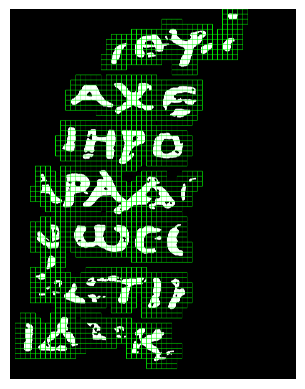

/home/stu/anaconda3/envs/dtt/lib/python3.9/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Cropping images - 2:   0%|          | 0/65 [00:00<?, ?it/s]

Merge images - 2:   0%|          | 0/4613 [00:00<?, ?it/s]

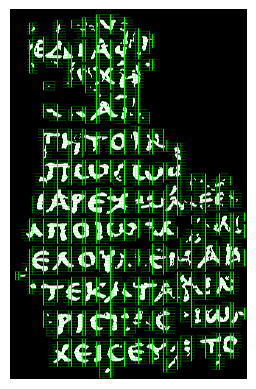

Cropping images - 3:   0%|          | 0/65 [00:00<?, ?it/s]

Merge images - 3:   0%|          | 0/961 [00:00<?, ?it/s]

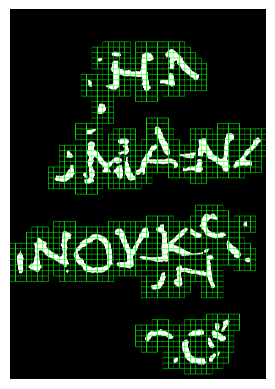

In [4]:
image_id_list_all = []
roi_id_list_all = []
x_pos_list_all = []
y_pos_list_all = []
for image_id in range(1, IMAGE_NUM+1):

    outputs = crop_image(image_id, INPUT_DIR, OUTPUT_DIR)

    image_id_list_all.extend(outputs["image_id_list"])
    roi_id_list_all.extend(outputs["roi_id_list"])
    x_pos_list_all.extend(outputs["x_pos_list"])
    y_pos_list_all.extend(outputs["y_pos_list"])

df = pd.DataFrame({
    "image_id": image_id_list_all,
    "roi_id": roi_id_list_all,
    "x_pos": x_pos_list_all,
    "y_pos": y_pos_list_all,
})
df.to_csv(str(OUTPUT_DIR / "train.csv"), index=False)